In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor
import torchvision

In [2]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, transform=ToTensor(), target_transform=None, download = True )
test_data = torchvision.datasets.CIFAR10(root='data', train=False, transform=ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
img, label = train_data[25]
# img, label

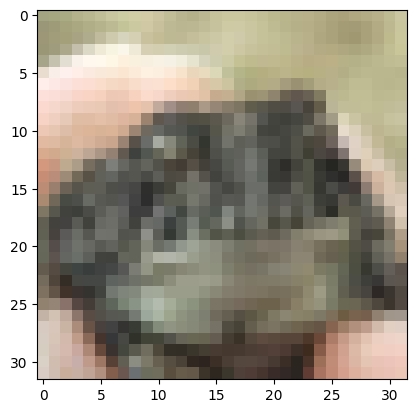

In [4]:
plt.imshow(img.numpy().transpose((1, 2, 0)))

In [5]:
i, l = train_data[0]
i.shape

torch.Size([3, 32, 32])

In [6]:
len(train_data)

50000

In [7]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [10]:
f = nn.Flatten()
f(train_features_batch[1]).shape

torch.Size([3, 1024])

In [11]:
class CIFAR1000(nn.Module):
  def __init__(self, input_layer, hidden_layer, output_layer):
    super().__init__()
    self.b1 = nn.Sequential(nn.Conv2d(in_channels=input_layer, out_channels=hidden_layer, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                torch.nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.b2 = nn.Sequential(nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1),
                                nn.ReLU(),
                                torch.nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.classify = nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=hidden_layer*8*8, out_features=output_layer),
                                  nn.Softmax(dim=-1))

  def forward(self, x):
    x = self.b1(x)
    x = self.b2(x)
    x = self.classify(x)
    return x


In [12]:
model = CIFAR1000(input_layer= 3,
                  hidden_layer=40,
                  output_layer=len(classes))
model


CIFAR1000(
  (b1): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
    (2): Softmax(dim=-1)
  )
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
def training(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                              y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def testing(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
          y_pred=test_pred.argmax(dim=1)
      )
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [16]:
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    training(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    testing(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

Epoch: 0
---------
Train loss: 2.09525 | Train accuracy: 35.82%
Test loss: 2.02883 | Test accuracy: 42.67%

Epoch: 1
---------
Train loss: 1.99019 | Train accuracy: 46.63%
Test loss: 1.97051 | Test accuracy: 48.63%

Epoch: 2
---------
Train loss: 1.94343 | Train accuracy: 51.36%
Test loss: 1.93978 | Test accuracy: 51.71%

Epoch: 3
---------
Train loss: 1.90957 | Train accuracy: 54.83%
Test loss: 1.89598 | Test accuracy: 56.14%

Epoch: 4
---------
Train loss: 1.88238 | Train accuracy: 57.59%
Test loss: 1.89030 | Test accuracy: 56.75%

Epoch: 5
---------
Train loss: 1.86428 | Train accuracy: 59.38%
Test loss: 1.87209 | Test accuracy: 58.53%

Epoch: 6
---------
Train loss: 1.84970 | Train accuracy: 60.98%
Test loss: 1.86826 | Test accuracy: 59.02%

Epoch: 7
---------
Train loss: 1.83730 | Train accuracy: 62.18%
Test loss: 1.85790 | Test accuracy: 60.03%

Epoch: 8
---------
Train loss: 1.82585 | Train accuracy: 63.40%
Test loss: 1.86323 | Test accuracy: 59.58%

Epoch: 9
---------
Train los

not very well performance, to deal with this from now exploring different architectures